# Install packages

In [ ]:
!pip install --upgrade matplotlib --user
!pip install dcor
!pip install vnstock

# Edhec tool kit

In [ ]:
import pandas as pd
import numpy as np
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())


def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol


def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")


from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x


def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())


def msr(riskfree_rate, er, cov, enc = 0):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    enc_constraint = {'type': 'ineq',
           'fun': lambda weights: risk_contribution(weights, cov) - enc
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol

    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return weights.x


def gmv(cov, enc = 0):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov, enc = enc)


def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights


def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)

        return ax


def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth,
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result


def summary_stats(r, riskfree_rate=0.03, n_periods_per_year = 12):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=n_periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=n_periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=n_periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })


def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val


import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1

    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights


def ff_analysis(r, factors):
    """
    Returns the loadings  of r on the Fama French Factors
    which can be read in using get_fff_returns()
    the index of r must be a (not necessarily proper) subset of the index of factors
    r is either a Series or a DataFrame
    """
    if isinstance(r, pd.Series):
        dependent_variable = r
        explanatory_variables = factors.loc[r.index]
        tilts = regress(dependent_variable, explanatory_variables).params
    elif isinstance(r, pd.DataFrame):
        tilts = pd.DataFrame({col: ff_analysis(r[col], factors) for col in r.columns})
    else:
        raise TypeError("r must be a Series or a DataFrame")
    return tilts

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[1]]
    return w/w.sum()

def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()

    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


# Lấy dữ liệu với VNSTOCK

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from vnstock import *

In [ ]:
ticker_list =['ACB','AGG','ANV','APH','ASM','BID','BMI','BMP','BVH','BWE','CII','CMG','CRE','CTD','CTG','DBC','DCM','DGC',
              'DGW','DHC','DIG','DPM','DRC','DXG','DXS','EIB','FIT','FLC','FPT','GAS','GEG','GEX','GMD','GTN','GVR','HBC',
              'HCM','HDB','HDG','HNG','HPG','HPX','HSG','HT1','IMP','ITA','KBC','KDC','KDH','KOS','LPB','MBB','MSB','MSN',
              'MWG','NLG','NT2','NVL','OCB','PC1','PDR','PHR','PLX','PNJ','POW','PPC','PTB','PVD','PVT','REE','SAB','SAM',
              'SBT','SCR','SCS','SJS','SSB','SSI','STB','SZC','TCB','TCH','TMS','TPB','VCB','VCG','VCI','VGC','VHC','VHM',
              'VIB','VIC','VJC','VND','VNM','VPB','VPI','VRE','VSH']

In [ ]:
df =  stock_historical_data(symbol='AAA',
                            start_date="2018-01-01",
                            end_date='2023-08-31')
df

,time,open,high,low,close,volume,ticker
0,2018-01-02,19208,19237,18744,19063,1563900,AAA
1,2018-01-03,19150,19237,18860,19121,1443310,AAA
2,2018-01-04,19121,19237,18889,19034,1533230,AAA
3,2018-01-05,19034,19150,18802,18918,1142150,AAA
4,2018-01-08,18918,19498,18715,19469,2204890,AAA
...,...,...,...,...,...,...,...
1411,2023-08-25,10550,10650,10400,10550,6367700,AAA
1412,2023-08-28,10600,10700,10400,10600,7647600,AAA
1413,2023-08-29,10700,11050,10600,10850,9125400,AAA
1414,2023-08-30,10900,11000,10650,10700,5731300,AAA


In [ ]:
df

,time,open,high,low,close,volume,ticker
0,2018-01-02,19208,19237,18744,19063,1563900,AAA
1,2018-01-03,19150,19237,18860,19121,1443310,AAA
2,2018-01-04,19121,19237,18889,19034,1533230,AAA
3,2018-01-05,19034,19150,18802,18918,1142150,AAA
4,2018-01-08,18918,19498,18715,19469,2204890,AAA
...,...,...,...,...,...,...,...
1411,2023-08-25,10550,10650,10400,10550,6367700,AAA
1412,2023-08-28,10600,10700,10400,10600,7647600,AAA
1413,2023-08-29,10700,11050,10600,10850,9125400,AAA
1414,2023-08-30,10900,11000,10650,10700,5731300,AAA


In [ ]:
import pandas as pd
import numpy as np
import datetime
data = pd.DataFrame()
for ticker in ticker_list:
    try:
        df =  stock_historical_data(symbol=ticker,
                                    start_date="2018-01-01",
                                    end_date='2023-08-31')

        if df.time[0] != datetime.date(2018, 1, 2) or df.time[len(df)-1] != datetime.date(2023, 8, 31):
              continue
        data = pd.concat([data, df])
    except:
        print(ticker)

Error in API response 

GTN


In [ ]:
df = data.copy()
df

,time,open,high,low,close,volume,ticker
0,2018-01-02,9250,9720,9200,9700,3657426,ACB
1,2018-01-03,9700,9770,9500,9670,5056543,ACB
2,2018-01-04,9670,9720,9600,9700,6365641,ACB
3,2018-01-05,9750,9870,9600,9700,6453452,ACB
4,2018-01-08,9700,10020,9700,10020,3879771,ACB
...,...,...,...,...,...,...,...
1410,2023-08-25,45700,45700,45600,45700,7500,VSH
1411,2023-08-28,45200,45700,45200,45300,43300,VSH
1412,2023-08-29,45300,45350,44200,45300,56900,VSH
1413,2023-08-30,45900,45900,44600,45800,3400,VSH


In [ ]:
df = df[~df.duplicated(subset=['ticker','time'] , keep='first')]
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
df

,Date,Open,High,Low,Close,Volume,Ticker
0,2018-01-02,9250,9720,9200,9700,3657426,ACB
1,2018-01-03,9700,9770,9500,9670,5056543,ACB
2,2018-01-04,9670,9720,9600,9700,6365641,ACB
3,2018-01-05,9750,9870,9600,9700,6453452,ACB
4,2018-01-08,9700,10020,9700,10020,3879771,ACB
...,...,...,...,...,...,...,...
1410,2023-08-25,45700,45700,45600,45700,7500,VSH
1411,2023-08-28,45200,45700,45200,45300,43300,VSH
1412,2023-08-29,45300,45350,44200,45300,56900,VSH
1413,2023-08-30,45900,45900,44600,45800,3400,VSH


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2018-01-02,9250,9720,9200,9700,3657426,ACB
2018-01-03,9700,9770,9500,9670,5056543,ACB
2018-01-04,9670,9720,9600,9700,6365641,ACB
2018-01-05,9750,9870,9600,9700,6453452,ACB
2018-01-08,9700,10020,9700,10020,3879771,ACB
...,...,...,...,...,...,...
2023-08-25,45700,45700,45600,45700,7500,VSH
2023-08-28,45200,45700,45200,45300,43300,VSH
2023-08-29,45300,45350,44200,45300,56900,VSH


In [ ]:
# Pivot với columns = 'Ticker'
df['Close_Diff'] = df.loc[:,'Close'] - df.loc[:,'Open']
df_close = df.pivot(columns='Ticker', values='Close')
df_open = df.pivot(columns='Ticker', values='Open')
df_close_diff = df.pivot(columns='Ticker', values='Close_Diff')
df_high = df.pivot(columns='Ticker', values='High')
df_low = df.pivot(columns='Ticker', values='Low')
df_close.head()

Ticker,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VHC,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,9700.0,8320.0,6420.0,20304.0,20540.0,53780.0,60520.0,19380.0,34810.0,15350.0,...,22510.0,4330.0,57456.0,119459.0,4570.0,116510.0,9910.0,22590.0,37526.0,13800.0
2018-01-03,9670.0,8090.0,6570.0,20154.0,21060.0,52680.0,59460.0,20680.0,35047.0,16059.0,...,23100.0,4350.0,59146.0,120106.0,4580.0,117830.0,9920.0,22460.0,37566.0,13640.0
2018-01-04,9700.0,8250.0,6660.0,20718.0,21450.0,52500.0,60080.0,21300.0,35756.0,16219.0,...,24020.0,4390.0,59514.0,120592.0,4620.0,118320.0,10270.0,22460.0,37407.0,13710.0
2018-01-05,9700.0,8250.0,6540.0,20605.0,21360.0,50850.0,58750.0,21050.0,35567.0,15680.0,...,23930.0,4560.0,58779.0,120592.0,4490.0,117620.0,10160.0,22520.0,37249.0,13550.0
2018-01-08,10020.0,8170.0,6510.0,20943.0,21250.0,51460.0,59810.0,20970.0,36135.0,15190.0,...,23810.0,4800.0,58999.0,120268.0,4620.0,115680.0,10630.0,22520.0,36773.0,13470.0


In [ ]:
# Chuyển đổi lợi nhuận ngày sang lợi nhuận tuần
df_close_pct = df_close.pct_change(1)
df_weekly_close = df_close_pct.resample('W').apply(lambda x: (1 + x).prod() - 1)
print(df_weekly_close)

Ticker           ACB       ANV       ASM       BID       BMI       BMP  \
Date                                                                     
2018-01-07  0.000000 -0.008413  0.018692  0.014825  0.039922 -0.054481   
2018-01-14  0.007216  0.090909  0.036697 -0.005484 -0.036049 -0.002557   
2018-01-21  0.010235  0.134444 -0.013274 -0.012834  0.034968  0.016956   
2018-01-28  0.066869  0.096964 -0.013453  0.208166 -0.073205  0.033346   
2018-02-04 -0.015195  0.026786 -0.050000  0.036948  0.048608 -0.010507   
...              ...       ...       ...       ...       ...       ...   
2023-08-06  0.099099 -0.040843 -0.033333  0.036403 -0.009787 -0.103061   
2023-08-13 -0.061475 -0.030220 -0.008621 -0.035124  0.007735 -0.003413   
2023-08-20 -0.043668 -0.086402 -0.082609 -0.053533  0.008102 -0.021689   
2023-08-27  0.002283  0.051163  0.009479  0.022624  0.072758  0.030338   
2023-09-03  0.029613  0.023599  0.018779  0.038717  0.000000 -0.002265   

Ticker           BVH       BWE       

# Phương pháp chọn cổ phiếu

## PCA + Cluster

In [ ]:
# Sử dụng dữ liệu khoảng '2018-01-01':'2021-01-01'
data_train = df_weekly_close.loc['2018-01-01':'2021-01-01']

### Dùng corr của dữ liệu

In [ ]:
# Dùng sample corr
train_corr = data_train.corr()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# Instantiate a PCA object with the number of components you want to keep
# You can specify the number of components or set it to None to keep all of them.
pca = PCA(n_components=0.95)

# Fit the PCA model to your data
pca.fit(train_corr)

# Transform your original data to the first two principal components
# You can specify the number of components to use by changing n_components.
transformed_data = pca.transform(train_corr)

# The transformed_data now contains the data in the reduced dimensionality
print("Original Data:")
print(train_corr)
print("\nTransformed Data (with 2 components):")
print(transformed_data)
print("\nExplained Variance Ratios:")
print(pca.explained_variance_ratio_)

Original Data:
Ticker       ACB       ANV       ASM       BID       BMI       BMP       BVH  \
Ticker                                                                         
ACB     1.000000  0.460050  0.480718  0.675837  0.341793  0.393735  0.470131   
ANV     0.460050  1.000000  0.445520  0.340427  0.347679  0.268516  0.372409   
ASM     0.480718  0.445520  1.000000  0.277882  0.298273  0.387185  0.221405   
BID     0.675837  0.340427  0.277882  1.000000  0.260598  0.347337  0.619382   
BMI     0.341793  0.347679  0.298273  0.260598  1.000000  0.392958  0.312381   
...          ...       ...       ...       ...       ...       ...       ...   
VNM     0.368856  0.236195  0.297274  0.385657  0.300238  0.263828  0.432174   
VPB     0.701350  0.438931  0.441855  0.607718  0.367106  0.373995  0.461296   
VPI     0.248416  0.292704  0.129469  0.234153  0.038211  0.147249  0.297612   
VRE     0.440330  0.409939  0.360471  0.401664  0.427319  0.395407  0.473419   
VSH     0.232080  0.14249

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters (k) you want to find in your data
n_clusters = 3  # You should adjust this based on your problem

# Instantiate the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters)

# Fit the KMeans model to your transformed data
kmeans.fit(transformed_data)

# Get the cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get the cluster centroids
cluster_centers = kmeans.cluster_centers_

# Print the cluster assignments for each data point
print("Cluster Assignments:")
print(cluster_labels)

# Print the cluster centroids (representative points for each cluster)
print("\nCluster Centers:")
print(cluster_centers)
print("\n Silhouette Score:")
print(silhouette_score(transformed_data, cluster_labels))

Cluster Assignments:
[1 2 2 1 2 2 1 2 0 2 2 1 0 2 2 1 0 2 2 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 2
 2 0 1 0 1 1 2 1 1 2 0 2 0 2 1 1 2 1 1 1 1 2 0 2 1 2 2 1 1 2 0 1 0 1 2 1 1
 2 1 1 2 1 0 1 0]

Cluster Centers:
[[ 1.33206628e+00  8.17755227e-02 -7.76206979e-02 -4.10064385e-02
  -3.57013498e-02 -8.08584870e-03 -2.41399421e-02  2.64634237e-02
   1.24569391e-02  9.61709626e-03 -4.39597409e-02  6.24591818e-03
  -2.33028685e-02  1.16072134e-02 -6.20089249e-03  3.48525089e-02
   7.70768194e-03  7.35989194e-03 -8.42120281e-03  1.32611241e-02
   1.29423690e-02  5.21388064e-03  7.21152931e-03  2.40183401e-02
   1.00982554e-02  3.16630338e-02  1.83938811e-04 -3.53199186e-03
   5.06574436e-03 -5.32606028e-03]
 [-7.19481738e-01  5.89629413e-02 -1.72062019e-03 -3.25709781e-02
  -9.19801440e-04  4.05214570e-03 -6.69058596e-03 -6.69414752e-03
   1.30634966e-02  7.29240667e-04 -1.07307346e-02 -1.84672045e-02
   5.10122337e-03 -1.36771157e-02 -8.49333838e-03 -2.83937416e-05
  -2.02598794e-03 -1.39214672e-0

In [ ]:
# Tìm ticker gần với cluster nhất
distances_to_centroids = np.sqrt(((transformed_data - cluster_centers[cluster_labels])**2).sum(axis=1))
train_corr_cluster = train_corr
train_corr_cluster['label'] = cluster_labels
train_corr_cluster['distances_to_centroids'] = distances_to_centroids
train_corr_cluster

Ticker,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH,label,distances_to_centroids
Ticker,,,,,,,,,,,,,,,,,,,,,
ACB,1.000000,0.460050,0.480718,0.675837,0.341793,0.393735,0.470131,0.372371,0.364082,0.442152,...,0.246874,0.511848,0.606533,0.368856,0.701350,0.248416,0.440330,0.232080,1,0.739846
ANV,0.460050,1.000000,0.445520,0.340427,0.347679,0.268516,0.372409,0.197004,0.252256,0.284274,...,0.201075,0.430813,0.450577,0.236195,0.438931,0.292704,0.409939,0.142495,2,0.944835
ASM,0.480718,0.445520,1.000000,0.277882,0.298273,0.387185,0.221405,0.271394,0.221634,0.243591,...,0.162390,0.297804,0.506065,0.297274,0.441855,0.129469,0.360471,0.237078,2,0.900965
BID,0.675837,0.340427,0.277882,1.000000,0.260598,0.347337,0.619382,0.285572,0.288632,0.546584,...,0.349648,0.583964,0.501802,0.385657,0.607718,0.234153,0.401664,0.109393,1,0.729141
BMI,0.341793,0.347679,0.298273,0.260598,1.000000,0.392958,0.312381,0.258658,0.338712,0.364679,...,0.205083,0.299872,0.324612,0.300238,0.367106,0.038211,0.427319,0.113227,2,0.889063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,0.368856,0.236195,0.297274,0.385657,0.300238,0.263828,0.432174,0.126319,0.142280,0.308727,...,0.353539,0.289985,0.274821,1.000000,0.415034,0.020299,0.397841,0.049062,2,0.975050
VPB,0.701350,0.438931,0.441855,0.607718,0.367106,0.373995,0.461296,0.377965,0.367369,0.389490,...,0.349212,0.504101,0.584337,0.415034,1.000000,0.129361,0.501295,0.206090,1,0.660815
VPI,0.248416,0.292704,0.129469,0.234153,0.038211,0.147249,0.297612,0.049636,0.148156,0.166510,...,0.285281,0.294952,0.181367,0.020299,0.129361,1.000000,0.190943,0.156228,0,0.992357


In [ ]:
# Danh sách 3 tickers
list_ticker_pca = []
for i in range(n_clusters):
  print(train_corr_cluster[train_corr_cluster['label'] == i].distances_to_centroids.idxmin())
  list_ticker_pca.append(train_corr_cluster[train_corr_cluster['label'] == i].distances_to_centroids.idxmin())

GEG
DXG
VGC


### Dùng Graphical Lasso CV


In [ ]:
# Import all the necessary packages
import numpy as np
import pandas as pd
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import GraphicalLasso
est = GraphicalLassoCV(max_iter = 1000).fit(df_weekly_close)


In [ ]:
# Precision matrix được ước lượng từ GraphicalLassoCV
train_cov = np.around(est.precision_, decimals=3)

In [ ]:
df_weekly_close

Ticker,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VHC,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07,0.000000,-0.008413,0.018692,0.014825,0.039922,-0.054481,-0.029247,0.086171,0.021747,0.021498,...,0.063083,0.053118,0.023026,0.009484,-0.017505,0.009527,0.025227,-0.003099,-0.007382,-0.018116
2018-01-14,0.007216,0.090909,0.036697,-0.005484,-0.036049,-0.002557,0.045277,0.055582,0.010628,-0.003827,...,-0.003343,0.179825,0.067490,0.044331,0.051225,-0.017004,0.061024,-0.002664,0.170206,0.011808
2018-01-21,0.010235,0.134444,-0.013274,-0.012834,0.034968,0.016956,0.089562,0.026553,-0.013159,-0.065941,...,-0.024319,0.091078,-0.016384,0.127332,0.004237,-0.020412,0.023191,0.047195,0.109087,-0.005106
2018-01-28,0.066869,0.096964,-0.013453,0.208166,-0.073205,0.033346,0.107458,0.025427,0.024019,0.065113,...,0.069618,-0.017036,0.017855,0.085713,0.054852,0.030108,0.078876,0.013605,-0.098358,0.005132
2018-02-04,-0.015195,0.026786,-0.050000,0.036948,0.048608,-0.010507,-0.038327,-0.010688,-0.020840,-0.001931,...,-0.034954,-0.006932,0.019882,0.023679,-0.010000,-0.022628,0.042017,-0.013423,0.001812,-0.013858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-06,0.099099,-0.040843,-0.033333,0.036403,-0.009787,-0.103061,0.009646,0.003257,0.053790,0.018634,...,0.009223,0.012048,0.207767,0.032720,0.014778,-0.025497,0.004525,-0.009074,-0.003472,0.012249
2023-08-13,-0.061475,-0.030220,-0.008621,-0.035124,0.007735,-0.003413,-0.008493,-0.004329,-0.027842,-0.004065,...,-0.024804,-0.021429,0.167203,0.000990,-0.026699,0.006849,-0.009009,-0.038462,0.071429,0.016502
2023-08-20,-0.043668,-0.086402,-0.082609,-0.053533,0.008102,-0.021689,-0.053533,-0.002174,-0.021480,-0.020408,...,-0.049531,-0.048662,-0.078512,-0.031652,-0.002494,-0.002721,-0.063636,-0.028571,-0.053659,-0.006494


In [ ]:
train_cov = pd.DataFrame(train_cov, columns = df_weekly_close.columns.to_list(), index = df_weekly_close.columns.to_list())
train_cov

,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VHC,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
ACB,739.455,-0.000,-0.000,-54.061,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-15.047,-0.000,-0.0,-30.233,-0.000,-34.204,-0.000,-0.000,-0.000
ANV,-0.000,296.782,-23.490,-0.000,-23.068,-0.000,-8.179,-0.0,-0.0,-0.000,...,-61.605,-0.000,-0.000,-0.0,-1.225,-0.000,-0.000,-0.000,-0.000,-27.779
ASM,-0.000,-23.490,277.544,-0.000,-0.000,-4.149,-0.000,-0.0,-0.0,-0.000,...,-11.932,-0.000,-0.000,-0.0,-3.890,-0.000,-0.000,-0.000,-16.963,-0.000
BID,-54.061,-0.000,-0.000,540.026,-0.000,-0.000,-52.681,-0.0,-0.0,-21.082,...,-0.000,-0.000,-0.000,-0.0,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
BMI,-0.000,-23.068,-0.000,-0.000,400.217,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.000,-0.000,-0.0,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.000,-0.000,-0.0,-0.000,1058.754,-0.000,-0.000,-0.000,-0.000
VPB,-34.204,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-34.484,-0.000,-0.0,-13.357,-0.000,501.223,-0.000,-14.350,-0.000
VPI,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.000,-0.000,-0.0,-0.000,-0.000,-0.000,1628.663,-0.000,-0.000
VRE,-0.000,-0.000,-16.963,-0.000,-0.000,-0.000,-9.063,-0.0,-0.0,-0.000,...,-0.000,-3.950,-24.365,-0.0,-0.000,-0.000,-14.350,-0.000,413.429,-0.000


In [ ]:
train_cov.shape

(82, 82)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# Instantiate a PCA object with the number of components you want to keep
# You can specify the number of components or set it to None to keep all of them.
pca = PCA(n_components=5)

# Fit the PCA model to your data
pca.fit(train_cov)

# Transform your original data to the first two principal components
# You can specify the number of components to use by changing n_components.
transformed_data = pca.transform(train_cov)

# The transformed_data now contains the data in the reduced dimensionality
print("Original Data:")
print(train_cov)
print("\nTransformed Data (with 2 components):")
print(transformed_data)
print("\nExplained Variance Ratios:")
print(pca.explained_variance_ratio_)

Original Data:
         ACB      ANV      ASM      BID      BMI    BMP     BVH  BWE  CII  \
ACB  739.455   -0.000   -0.000  -54.061   -0.000 -0.000  -0.000 -0.0 -0.0   
ANV   -0.000  296.782  -23.490   -0.000  -23.068 -0.000  -8.179 -0.0 -0.0   
ASM   -0.000  -23.490  277.544   -0.000   -0.000 -4.149  -0.000 -0.0 -0.0   
BID  -54.061   -0.000   -0.000  540.026   -0.000 -0.000 -52.681 -0.0 -0.0   
BMI   -0.000  -23.068   -0.000   -0.000  400.217 -0.000  -0.000 -0.0 -0.0   
..       ...      ...      ...      ...      ...    ...     ...  ...  ...   
VNM   -0.000   -0.000   -0.000   -0.000   -0.000 -0.000  -0.000 -0.0 -0.0   
VPB  -34.204   -0.000   -0.000   -0.000   -0.000 -0.000  -0.000 -0.0 -0.0   
VPI   -0.000   -0.000   -0.000   -0.000   -0.000 -0.000  -0.000 -0.0 -0.0   
VRE   -0.000   -0.000  -16.963   -0.000   -0.000 -0.000  -9.063 -0.0 -0.0   
VSH   -0.000  -27.779   -0.000   -0.000   -0.000 -0.000  -0.000 -0.0 -0.0   

        CMG  ...     VHC     VIB     VIC  VJC     VND       

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters (k) you want to find in your data
n_clusters = 5  # You should adjust this based on your problem

# Instantiate the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters)

# Fit the KMeans model to your transformed data
kmeans.fit(transformed_data)

# Get the cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get the cluster centroids
cluster_centers = kmeans.cluster_centers_

# Print the cluster assignments for each data point
print("Cluster Assignments:")
print(cluster_labels)

# Print the cluster centroids (representative points for each cluster)
print("\nCluster Centers:")
print(cluster_centers)
print("\n Silhouette Score:")
print(silhouette_score(transformed_data, cluster_labels))

Cluster Assignments:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 1 2 1 1]

Cluster Centers:
[[-2.46943931e+01 -2.85562252e+01 -1.31090381e+02  7.83927699e+02
  -1.99135786e+02]
 [-1.95544041e+01 -1.26897011e+01 -9.43033917e+00 -1.15743303e+01
   3.78310614e+00]
 [ 1.60919115e+03  8.07662446e+00  2.84941837e+00  2.71724209e+00
  -1.59854078e+00]
 [-3.28658557e+01  1.04572651e+03  1.48184356e+01  1.27186959e+01
  -7.38837017e+00]
 [-2.63873818e+01 -3.54502220e+01  8.48988982e+02  1.03434124e+02
  -8.69595825e+01]]

 Silhouette Score:
0.8826050583501852


In [ ]:
distances_to_centroids = np.sqrt(((transformed_data - cluster_centers[cluster_labels])**2).sum(axis=1))
train_cov_cluster = train_cov
train_cov_cluster['label'] = cluster_labels
train_cov_cluster['distances_to_centroids'] = distances_to_centroids
train_cov_cluster

,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH,label,distances_to_centroids
ACB,739.455,-0.000,-0.000,-54.061,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-30.233,-0.000,-34.204,-0.000,-0.000,-0.000,1,524.407811
ANV,-0.000,296.782,-23.490,-0.000,-23.068,-0.000,-8.179,-0.0,-0.0,-0.000,...,-0.000,-0.0,-1.225,-0.000,-0.000,-0.000,-0.000,-27.779,1,14.177296
ASM,-0.000,-23.490,277.544,-0.000,-0.000,-4.149,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-3.890,-0.000,-0.000,-0.000,-16.963,-0.000,1,7.117224
BID,-54.061,-0.000,-0.000,540.026,-0.000,-0.000,-52.681,-0.0,-0.0,-21.082,...,-0.000,-0.0,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,1,135.348045
BMI,-0.000,-23.068,-0.000,-0.000,400.217,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,1,11.032399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-0.000,1058.754,-0.000,-0.000,-0.000,-0.000,3,0.000000
VPB,-34.204,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-13.357,-0.000,501.223,-0.000,-14.350,-0.000,1,6.343795
VPI,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.000,...,-0.000,-0.0,-0.000,-0.000,-0.000,1628.663,-0.000,-0.000,2,0.000000
VRE,-0.000,-0.000,-16.963,-0.000,-0.000,-0.000,-9.063,-0.0,-0.0,-0.000,...,-24.365,-0.0,-0.000,-0.000,-14.350,-0.000,413.429,-0.000,1,30.895580


In [ ]:
list_ticker_pca = []
for i in range(n_clusters):
  print(train_cov_cluster[train_cov_cluster['label'] == i].distances_to_centroids.idxmin())
  list_ticker_pca.append(train_cov_cluster[train_cov_cluster['label'] == i].distances_to_centroids.idxmin())

FPT
CII
VPI
VNM
SCS


## Network Graph

In [ ]:
df_train_close = df_close.loc['2018-01-01':'2021-01-01']
df_train_open = df_open.loc['2018-01-01':'2021-01-01']
df_train_close_diff = df_close_diff.loc['2018-01-01':'2021-01-01']
df_train_high = df_high.loc['2018-01-01':'2021-01-01']
df_train_low = df_low.loc['2018-01-01':'2021-01-01']

In [ ]:
#creates a list of stocks
stocks = df_train_close.columns.tolist()

#list of training DataFrames containing each time-series
df_train_list = [df_train_close, df_train_open, df_train_close_diff, df_train_high, df_train_low]

#detrends each time-series for each DataFrame
for df in df_train_list:
    for s in stocks:
        df[s] = df[s].diff()

#drops all missing values in each DataFrame
for df in df_train_list:
    df.dropna(inplace=True)

In [ ]:
#imports the dcor module to calculate distance correlation
import dcor

#function to compute the distance correlation (dcor) matrix from a DataFrame and output a DataFrame
#of dcor values.
def df_distance_correlation(df_train):

    #initializes an empty DataFrame
    df_train_dcor = pd.DataFrame(index=stocks, columns=stocks)

    #initialzes a counter at zero
    k=0

    #iterates over the time series of each stock
    for i in stocks:

        #stores the ith time series as a vector
        v_i = df_train.loc[:, i].values

        #iterates over the time series of each stock subect to the counter k
        for j in stocks[k:]:

            #stores the jth time series as a vector
            v_j = df_train.loc[:, j].values

            #computes the dcor coefficient between the ith and jth vectors
            dcor_val = dcor.distance_correlation(v_i, v_j)

            #appends the dcor value at every ij entry of the empty DataFrame
            df_train_dcor.at[i,j] = dcor_val

            #appends the dcor value at every ji entry of the empty DataFrame
            df_train_dcor.at[j,i] = dcor_val

        #increments counter by 1
        k+=1

    #returns a DataFrame of dcor values for every pair of stocks
    return df_train_dcor

In [ ]:
df_train_dcor_list = [df_distance_correlation(df) for df in df_train_list]

In [ ]:
#imports the NetworkX module
import networkx as nx

# takes in a pre-processed dataframe and returns a time-series correlation
# network with pairwise distance correlation values as the edges
def build_corr_nx(df_train):

    # converts the distance correlation dataframe to a numpy matrix with dtype float
    cor_matrix = df_train.values.astype('float')

    # Since dcor ranges between 0 and 1, (0 corresponding to independence and 1
    # corresponding to dependence), 1 - cor_matrix results in values closer to 0
    # indicating a higher degree of dependence where values close to 1 indicate a lower degree of
    # dependence. This will result in a network with nodes in close proximity reflecting the similarity
    # of their respective time-series and vice versa.
    sim_matrix = 1 - cor_matrix

    # transforms the similarity matrix into a graph
    G = nx.from_numpy_array(sim_matrix)

    # extracts the indices (i.e., the stock names from the dataframe)
    stock_names = df_train.index.values

    # relabels the nodes of the network with the stock names
    G = nx.relabel_nodes(G, lambda x: stock_names[x])

    # assigns the edges of the network weights (i.e., the dcor values)
    G.edges(data=True)

    # copies G
    ## we need this to delete edges or othwerwise modify G
    H = G.copy()

    # iterates over the edges of H (the u-v pairs) and the weights (wt)
    for (u, v, wt) in G.edges.data('weight'):
        # selects edges with dcor values less than or equal to 0.33
        if wt >= 1 - 0.1:
            # removes the edges
            H.remove_edge(u, v)

        # selects self-edges
        if u == v:
            # removes the self-edges
            H.remove_edge(u, v)

    # returns the final stock correlation network
    return H

In [ ]:
#builds the distance correlation networks for the Open, Close, High, Low, and Close_diff time series
H_close = build_corr_nx(df_train_dcor_list[0])
H_open = build_corr_nx(df_train_dcor_list[1])
H_close_diff = build_corr_nx(df_train_dcor_list[2])
H_high = build_corr_nx(df_train_dcor_list[3])
H_low = build_corr_nx(df_train_dcor_list[4])

In [ ]:
# initializes a DataFrame full of zeros
df_zeros = pd.DataFrame(index=stocks, columns=stocks).fillna(0)

# iterates over the length of the DataFrame list containg the Open, High, Low, Close, and Close_diff
# time series
for i in range(len(df_train_list)):

    # Adds the distance correlation DataFrames of the Open, High, Low, Close, and Close_diff
    # time series together
    df_zeros += df_train_dcor_list[i]

    # Takes the average of the distance correlation DataFrames
    df_master = df_zeros/len(df_train_list)

# Builds the master network with the averaged distance correlation DataFrame
H_master = build_corr_nx(df_master)

In [ ]:
# a function to generate a random approximate MIS
### WARNING: rerunning kernel will produce different MISs
def generate_mis(G, sample_size, nodes=None):

    """Returns a random approximate maximum independent set.

    Parameters
    ----------
    G: NetworkX graph
       Undirected graph

    nodes: list, optional
        a list of nodes the approximate maximum independent set must contain.

    sample_size: int
        number of maximal independent sets sampled from

    Returns
    -------
    max_ind_set: list or None
        list of nodes in the apx-maximum independent set
        NoneType object if any two specified nodes share an edge

    """

    # list of maximal independent sets
    max_ind_set_list=[]

    # iterates from 0 to the number of samples chosen
    for i in range(sample_size):

        # for each iteration generates a random maximal independent set that contains
        # UnitedHealth and Amazon
        max_ind_set = nx.maximal_independent_set(G, nodes=nodes, seed=i)

        # if set is not a duplicate
        if max_ind_set not in max_ind_set_list:

            # appends set to the above list
            max_ind_set_list.append(max_ind_set)

        # otherwise pass duplicate set
        else:
            pass

    # list of the lengths of the maximal independent sets
    mis_len_list=[]

    # iterates over the above list
    for i in max_ind_set_list:

        # appends the lengths of each set to the above list
        mis_len_list.append(len(i))

    # extracts the largest maximal independent set, i.e., the maximum independent set (MIS)
    ## Note: this MIS may not be unique as it is possible there are many MISs of the same length
    max_ind_set = max_ind_set_list[mis_len_list.index(max(mis_len_list))]

    return max_ind_set



max_ind_set = generate_mis(H_master, nodes=None, sample_size=100)
print(max_ind_set)

['EIB', 'KOS', 'VSH', 'IMP', 'TMS']


# Danh mục GMV, EW


In [ ]:
df_weekly_close

Ticker,ACB,ANV,ASM,BID,BMI,BMP,BVH,BWE,CII,CMG,...,VHC,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07,0.000000,-0.008413,0.018692,0.014825,0.039922,-0.054481,-0.029247,0.086171,0.021747,0.021498,...,0.063083,0.053118,0.023026,0.009484,-0.017505,0.009527,0.025227,-0.003099,-0.007382,-0.018116
2018-01-14,0.007216,0.090909,0.036697,-0.005484,-0.036049,-0.002557,0.045277,0.055582,0.010628,-0.003827,...,-0.003343,0.179825,0.067490,0.044331,0.051225,-0.017004,0.061024,-0.002664,0.170206,0.011808
2018-01-21,0.010235,0.134444,-0.013274,-0.012834,0.034968,0.016956,0.089562,0.026553,-0.013159,-0.065941,...,-0.024319,0.091078,-0.016384,0.127332,0.004237,-0.020412,0.023191,0.047195,0.109087,-0.005106
2018-01-28,0.066869,0.096964,-0.013453,0.208166,-0.073205,0.033346,0.107458,0.025427,0.024019,0.065113,...,0.069618,-0.017036,0.017855,0.085713,0.054852,0.030108,0.078876,0.013605,-0.098358,0.005132
2018-02-04,-0.015195,0.026786,-0.050000,0.036948,0.048608,-0.010507,-0.038327,-0.010688,-0.020840,-0.001931,...,-0.034954,-0.006932,0.019882,0.023679,-0.010000,-0.022628,0.042017,-0.013423,0.001812,-0.013858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-06,0.099099,-0.040843,-0.033333,0.036403,-0.009787,-0.103061,0.009646,0.003257,0.053790,0.018634,...,0.009223,0.012048,0.207767,0.032720,0.014778,-0.025497,0.004525,-0.009074,-0.003472,0.012249
2023-08-13,-0.061475,-0.030220,-0.008621,-0.035124,0.007735,-0.003413,-0.008493,-0.004329,-0.027842,-0.004065,...,-0.024804,-0.021429,0.167203,0.000990,-0.026699,0.006849,-0.009009,-0.038462,0.071429,0.016502
2023-08-20,-0.043668,-0.086402,-0.082609,-0.053533,0.008102,-0.021689,-0.053533,-0.002174,-0.021480,-0.020408,...,-0.049531,-0.048662,-0.078512,-0.031652,-0.002494,-0.002721,-0.063636,-0.028571,-0.053659,-0.006494


In [ ]:
def sample_cov_rank(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    data_rank = round(r*100,2).rank()
    return data_rank.cov()

def weight_gmv_rank(r, cov_estimator=sample_cov_rank, **kwargs):
    """
    Produces the weights of the GMV portfolio given a
    covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def shrinkage_cov_rank(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    data_rank = round(r*100,2).rank()
    prior = cc_cov(data, **kwargs)
    sample = sample_cov(data, **kwargs)
    return delta*prior + (1-delta)*sample

def cc_cov_rank(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    r = round(r*100,2).rank()
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)

def semidownside_cov(r, **kwargs):
    negative_returns = r[r < r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return negative_returns.cov()

def semidownside_cc_cov(r, **kwargs):
    negative_returns = r[r < r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return cc_cov(negative_returns)

def semidownside_shrinkage_cov(r,delta=0.5, **kwargs):
    negative_returns = r[r < r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return shrinkage_cov(negative_returns, delta=delta)

def semidownside_cov_rank(r, **kwargs):
    r = round(r*100,2).rank()
    negative_returns = r[r < r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return negative_returns.cov()

def semiupside_cov(r, **kwargs):
    negative_returns = r[r > r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return negative_returns.cov()

def semiupside_cov_rank(r, **kwargs):
    r = round(r*100,2).rank()
    negative_returns = r[r > r.mean(axis = 0)]
    negative_returns = negative_returns.fillna(negative_returns.mean())
    return negative_returns.cov()

def semibothsides_cov(r,delta = 0.5, **kwargs):
    downside = semidownside_cov(r)
    upside = semiupside_cov(r)
    return delta*downside + (1-delta)*upside

## Dùng PCA + Cluster

In [ ]:
data = df_weekly_close[list_ticker_pca]

In [ ]:
data = data.loc["2021-01-01":"2023-09-01"]

In [ ]:
btr_gmv = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=cc_cov)

In [ ]:
w_ccrank_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=cc_cov_rank)
w_sample_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=sample_cov)
w_samplerank_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=sample_cov_rank)

In [ ]:
btr = pd.DataFrame({'GMV cc_cov':btr_gmv, 'GMV cc_cov_rank':w_ccrank_r, 'GMV sample_cov':w_sample_r, 'GMV sample_cov_rank':w_samplerank_r})
btr

,GMV cc_cov,GMV cc_cov_rank,GMV sample_cov,GMV sample_cov_rank
Date,,,,
2021-01-03,NaN,NaN,NaN,NaN
2021-01-10,NaN,NaN,NaN,NaN
2021-01-17,NaN,NaN,NaN,NaN
2021-01-24,NaN,NaN,NaN,NaN
2021-01-31,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-07-30,0.044786,0.036679,0.049074,0.038162
2023-08-06,-0.010021,0.001139,-0.004320,0.007435
2023-08-13,-0.024719,-0.020234,-0.021224,-0.016866


In [ ]:
summary_stats(btr, riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV cc_cov,0.135903,0.154523,0.653413,4.667018,0.027343,NaN,0.498872,-0.108481
GMV cc_cov_rank,0.114338,0.197131,0.155494,3.491626,0.040652,NaN,0.287162,-0.268595
GMV sample_cov,0.127635,0.150040,0.663891,4.711569,0.026547,NaN,0.461475,-0.127505
GMV sample_cov_rank,0.040153,0.172136,-0.372358,4.743343,0.039614,NaN,-0.080203,-0.304416


<Axes: title={'center': 'Portfolios'}, xlabel='Date'>

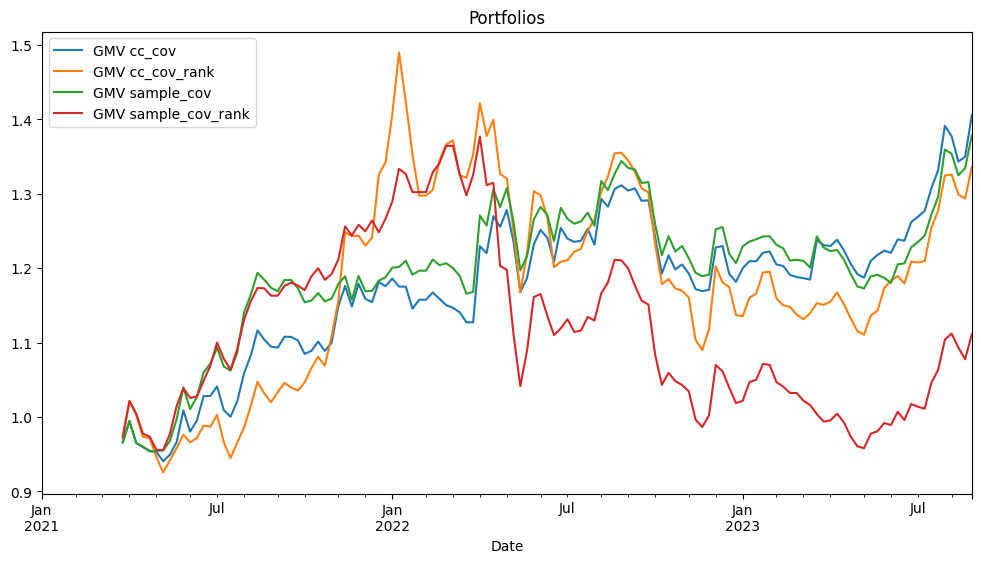

In [ ]:
(1+btr).cumprod().plot(figsize=(12, 6), title="Portfolios")

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125719,0.197151,0.155436,3.49129,0.040658,0.053872,0.314721,-0.268747


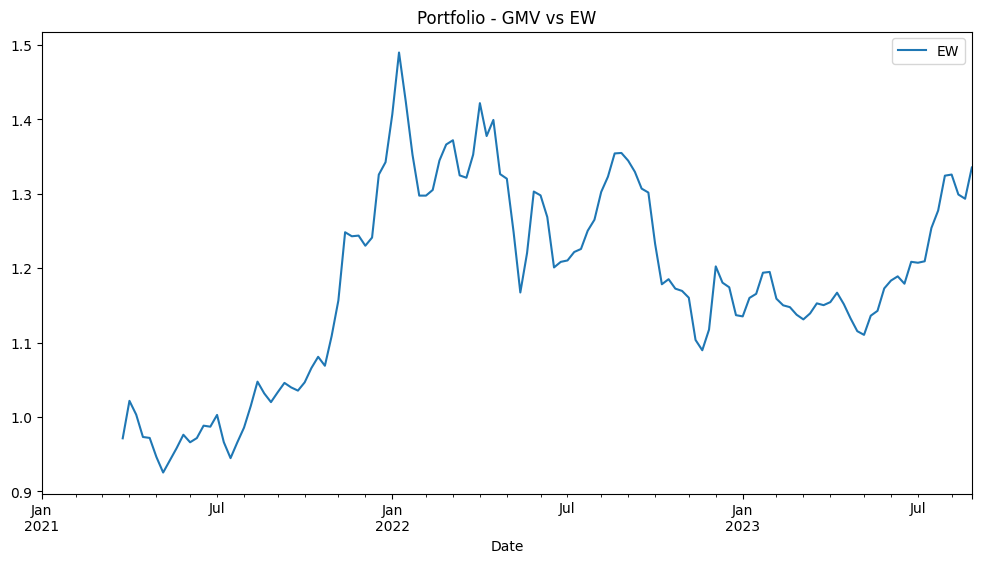

In [ ]:
ewr = backtest_ws(data, estimation_window=12, weighting=weight_ew)
btr = pd.DataFrame({"EW": ewr})
(1+btr).cumprod().plot(figsize=(12, 6), title="Portfolio - GMV vs EW")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125719,0.197151,0.155436,3.49129,0.040658,0.053872,0.314721,-0.268747
GMV-Shrink rank 0.5,0.088920,0.132829,0.051310,3.61201,0.027876,0.037369,0.205555,-0.135870


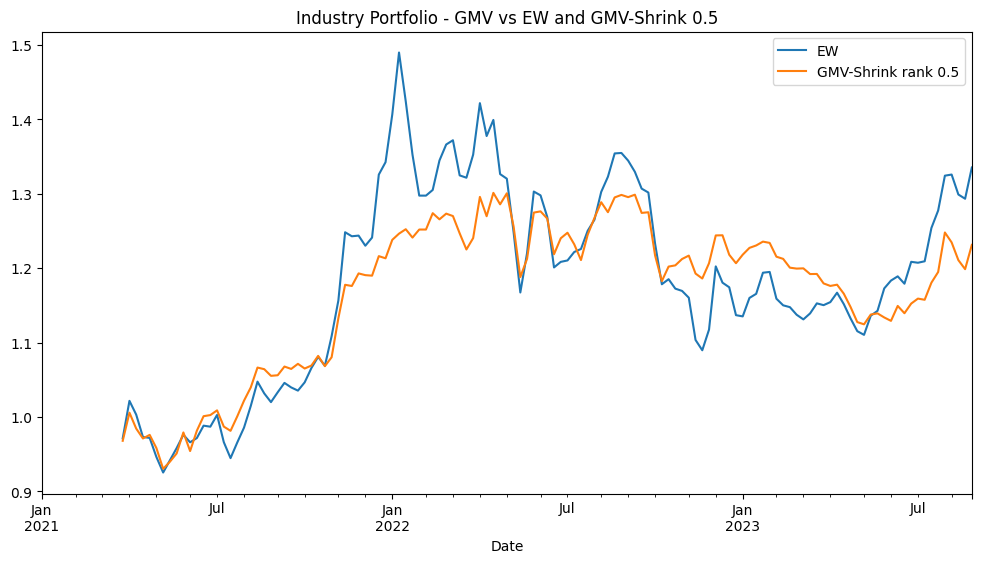

In [ ]:
mv_sh_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=shrinkage_cov_rank, delta=0.5, enc = 40)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink rank 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolio - GMV vs EW and GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125719,0.197151,0.155436,3.491290,0.040658,0.053872,0.314721,-0.268747
GMV-Shrink 0.5,0.142479,0.151268,0.643034,4.662532,0.026905,0.036911,0.514899,-0.111838


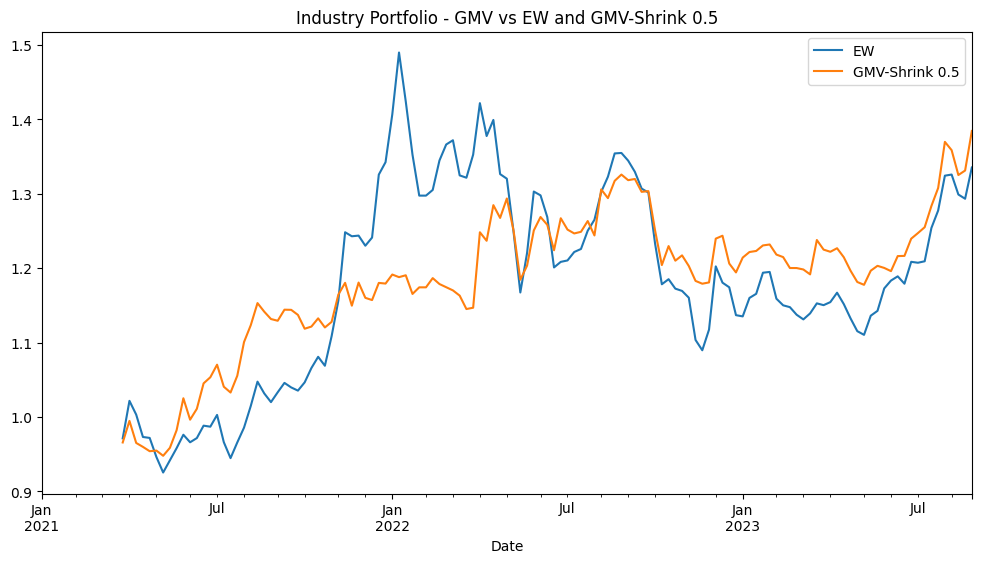

In [ ]:
mv_sh_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolio - GMV vs EW and GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125719,0.197151,0.155436,3.491290,0.040658,0.053872,0.314721,-0.268747
GMV-Shrink 0.5,0.142479,0.151268,0.643034,4.662532,0.026905,0.036911,0.514899,-0.111838
GMV-SemiDownside,0.097399,0.163712,0.512535,4.027495,0.031278,0.042288,0.215664,-0.151860


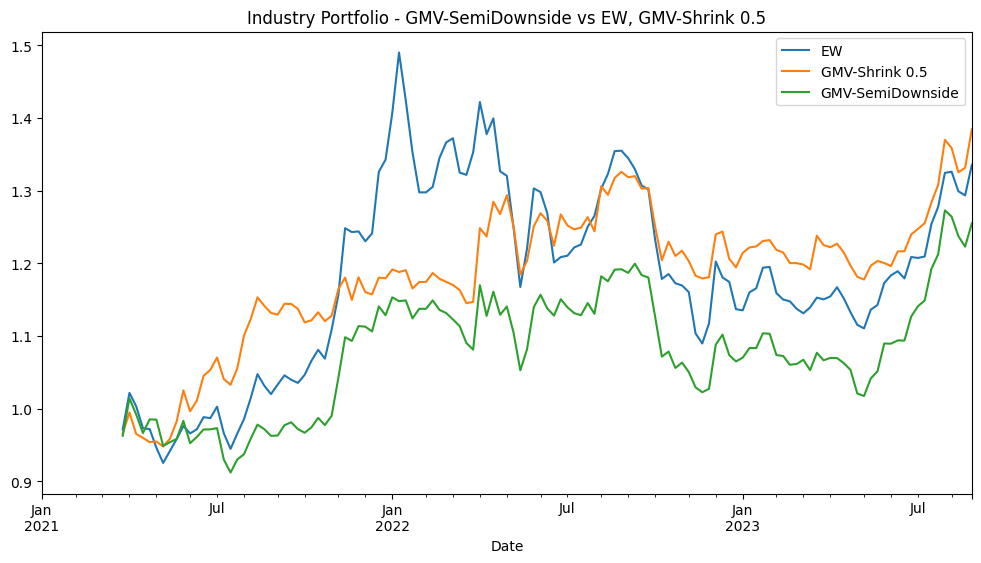

In [ ]:
mv_sd_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_cov)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125719,0.197151,0.155436,3.491290,0.040658,0.053872,0.314721,-0.268747
GMV-Shrink 0.5,0.142479,0.151268,0.643034,4.662532,0.026905,0.036911,0.514899,-0.111838
GMV-SemiDownside,0.097399,0.163712,0.512535,4.027495,0.031278,0.042288,0.215664,-0.151860
GMV-SemiUpside,0.273131,0.178853,0.658501,4.736351,0.029989,0.042515,1.125467,-0.128706
GMV-SemiBothsides,0.184410,0.161298,0.628033,4.510145,0.028320,0.040007,0.728413,-0.122029


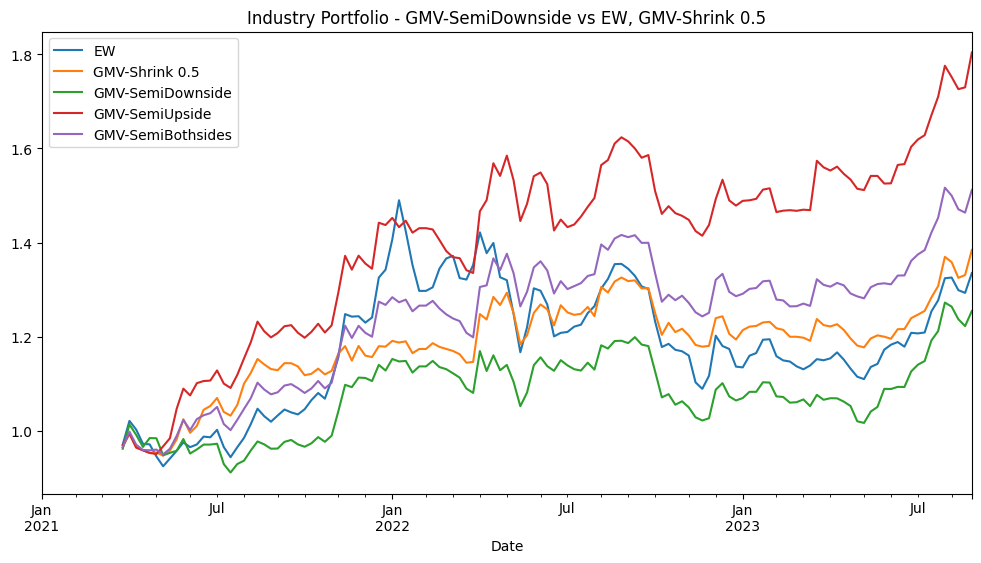

In [ ]:
mv_su_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semiupside_cov)
mv_sb_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semibothsides_cov)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r, 'GMV-SemiUpside': mv_su_r, 'GMV-SemiBothsides': mv_sb_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV-Shrink 0.5,0.142479,0.151268,0.643034,4.662532,0.026905,0.036911,0.514899,-0.111838
GMV-SemiDownside,0.097399,0.163712,0.512535,4.027495,0.031278,0.042288,0.215664,-0.151860
GMV-SemiUpside,0.273131,0.178853,0.658501,4.736351,0.029989,0.042515,1.125467,-0.128706
GMV-SemiBothsides,0.184410,0.161298,0.628033,4.510145,0.028320,0.040007,0.728413,-0.122029
GMV-SemiDownside_cc_cov,0.085584,0.161227,0.347164,3.881623,0.032160,0.042815,0.149782,-0.206045
GMV-SemiDownside_shrinkage_cov,0.094539,0.159920,0.413436,4.067659,0.031210,0.042094,0.203894,-0.182572


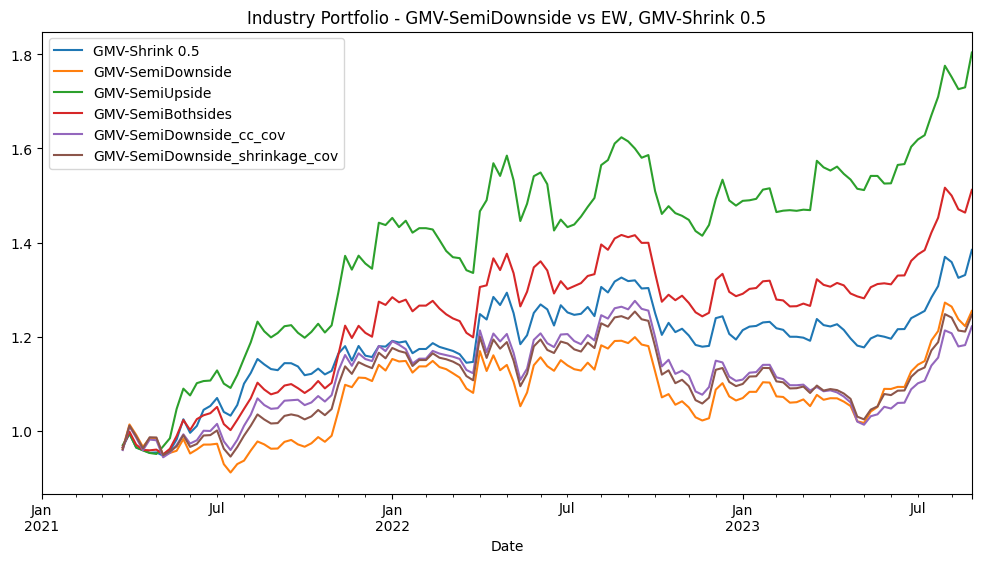

In [ ]:
mv_scc_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_cc_cov)
mv_sshrink_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_shrinkage_cov)
btr = pd.DataFrame({'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r, 'GMV-SemiUpside': mv_su_r, 'GMV-SemiBothsides': mv_sb_r,
                    'GMV-SemiDownside_cc_cov': mv_scc_r, 'GMV-SemiDownside_shrinkage_cov': mv_sshrink_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

## Dùng Network Graph


In [ ]:
data = df_weekly_close[max_ind_set]
data = data.loc["2021-01-01":"2023-09-01"]
data

Ticker,EIB,KOS,VSH,IMP,TMS
Date,,,,,
2021-01-03,0.007413,2.531646e-02,0.010773,1.778305e-03,0.046663
2021-01-10,0.060338,8.230453e-03,0.053918,2.840237e-02,0.038830
2021-01-17,0.077724,0.000000e+00,-0.005354,5.178366e-03,0.012921
2021-01-24,-0.068255,2.220446e-16,-0.024581,-2.747567e-02,0.000000
2021-01-31,-0.177609,-1.020408e-02,-0.033049,-5.297234e-03,-0.078815
...,...,...,...,...,...
2023-07-30,0.017616,9.102731e-03,0.020455,9.987893e-03,0.020334
2023-08-06,0.163878,3.865979e-03,0.012249,-3.940665e-02,0.022064
2023-08-13,0.018840,0.000000e+00,0.016502,-1.110223e-16,-0.033890


<Axes: title={'center': 'Portfolios'}, xlabel='Date'>

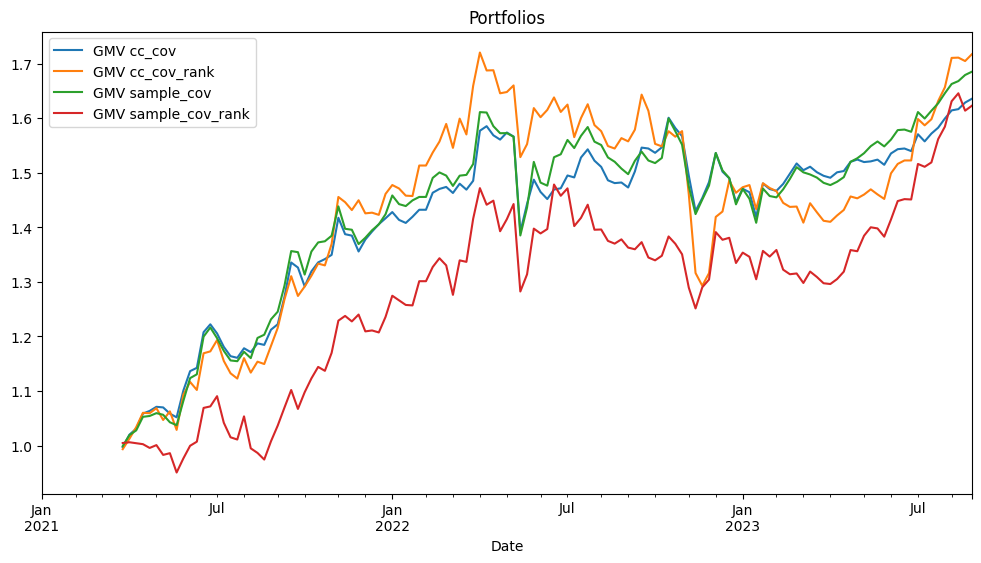

In [ ]:
btr_gmv = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=cc_cov)
w_ccrank_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=cc_cov_rank)
w_sample_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=sample_cov)
w_samplerank_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=sample_cov_rank)
btr = pd.DataFrame({'GMV cc_cov':btr_gmv, 'GMV cc_cov_rank':w_ccrank_r, 'GMV sample_cov':w_sample_r, 'GMV sample_cov_rank':w_samplerank_r})
(1+btr).cumprod().plot(figsize=(12, 6), title="Portfolios")

In [ ]:
summary_stats(btr, riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV cc_cov,0.202059,0.150297,-0.951121,10.081129,0.032342,NaN,0.930758,-0.122165
GMV cc_cov_rank,0.224150,0.187242,-0.464061,5.442046,0.039972,NaN,0.859079,-0.248440
GMV sample_cov,0.215556,0.160448,-0.799632,9.098912,0.034132,NaN,0.951723,-0.140285
GMV sample_cov_rank,0.198535,0.188759,-0.479099,5.305274,0.040951,NaN,0.723343,-0.153565


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.247757,0.187387,-0.46289,5.432413,0.040003,0.055688,0.946283,-0.248567


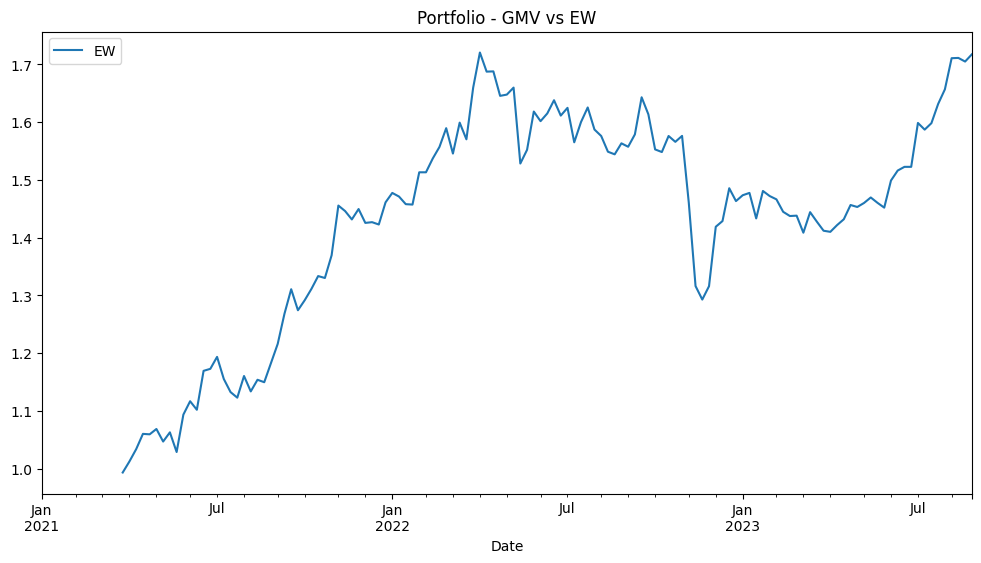

In [ ]:
ewr = backtest_ws(data, estimation_window=12, weighting=weight_ew)
btr = pd.DataFrame({"EW": ewr})
(1+btr).cumprod().plot(figsize=(12, 6), title="Portfolio - GMV vs EW")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.247757,0.187387,-0.462890,5.432413,0.040003,0.055688,0.946283,-0.248567
GMV-Shrink rank 0.5,0.224705,0.145040,-0.280064,5.053726,0.029582,0.044914,1.072502,-0.113589


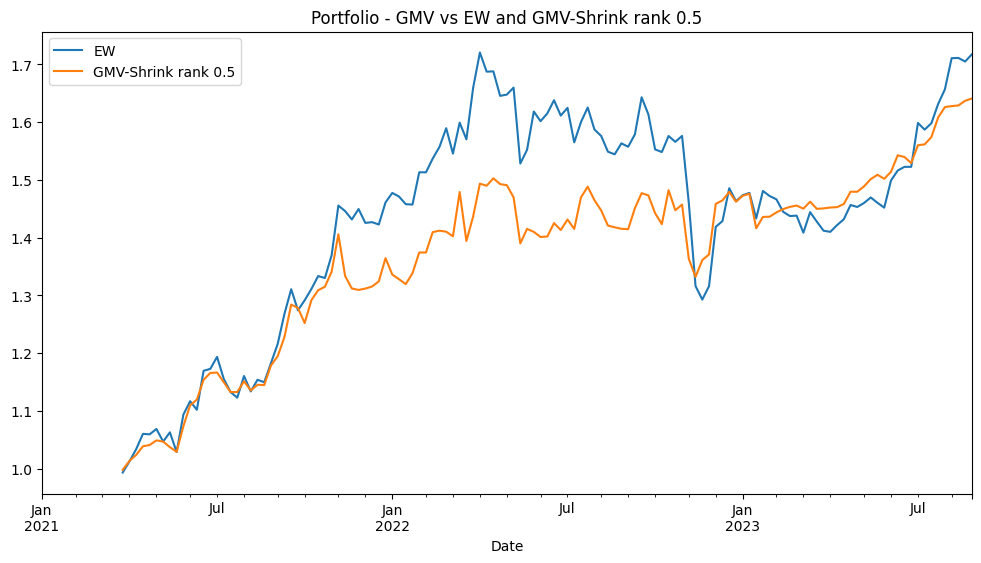

In [ ]:
mv_sh_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=shrinkage_cov_rank, delta=0.5, enc = 40)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink rank 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio - GMV vs EW and GMV-Shrink rank 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.247757,0.187387,-0.462890,5.432413,0.040003,0.055688,0.946283,-0.248567
GMV-Shrink 0.5,0.227252,0.151834,-0.972795,10.186627,0.032713,0.043611,1.040342,-0.129439


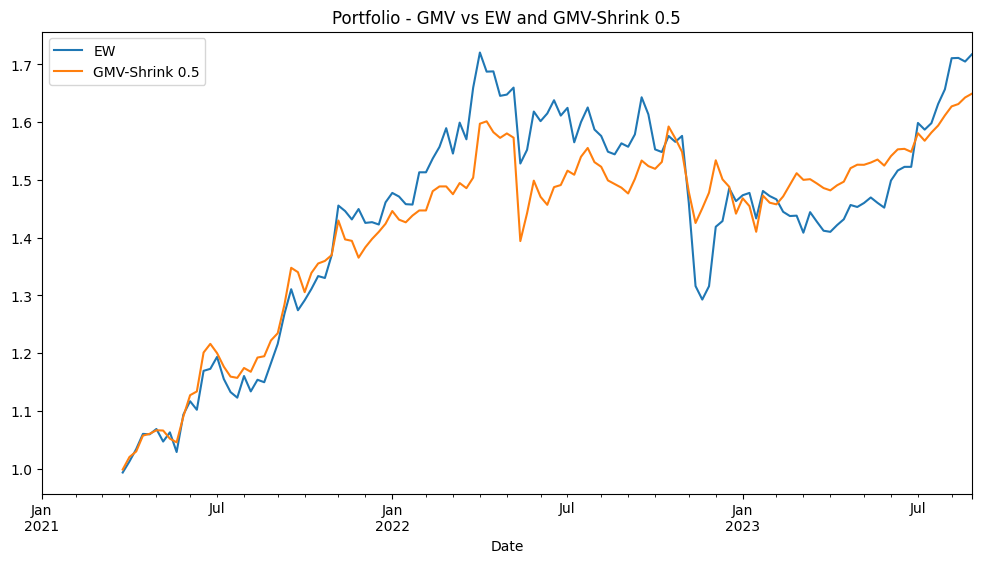

In [ ]:
mv_sh_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio - GMV vs EW and GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.247757,0.187387,-0.462890,5.432413,0.040003,0.055688,0.946283,-0.248567
GMV-Shrink 0.5,0.227252,0.151834,-0.972795,10.186627,0.032713,0.043611,1.040342,-0.129439
GMV-SemiDownside,0.137508,0.150540,-0.958246,7.665013,0.034851,0.049933,0.486193,-0.186158


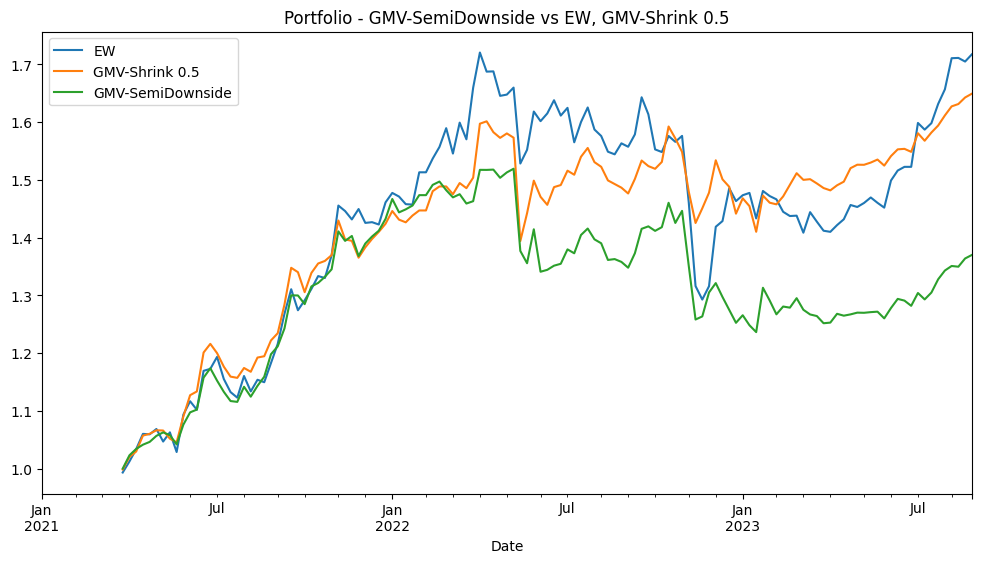

In [ ]:
mv_sd_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_cov)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.247757,0.187387,-0.462890,5.432413,0.040003,0.055688,0.946283,-0.248567
GMV-Shrink 0.5,0.227252,0.151834,-0.972795,10.186627,0.032713,0.043611,1.040342,-0.129439
GMV-SemiDownside,0.137508,0.150540,-0.958246,7.665013,0.034851,0.049933,0.486193,-0.186158
GMV-SemiUpside,0.188790,0.178635,-0.834027,9.783181,0.039096,0.057124,0.680849,-0.158982
GMV-SemiBothsides,0.180499,0.161649,-1.186474,10.325375,0.036916,0.052983,0.703972,-0.146826


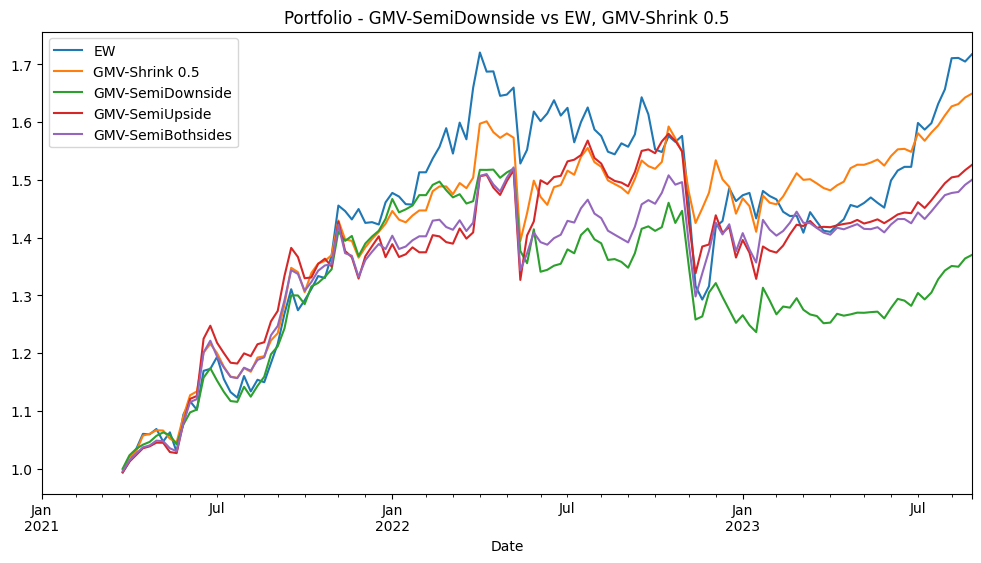

In [ ]:
mv_su_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semiupside_cov)
mv_sb_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semibothsides_cov)
btr = pd.DataFrame({"EW": ewr, 'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r, 'GMV-SemiUpside': mv_su_r, 'GMV-SemiBothsides': mv_sb_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV-Shrink 0.5,0.227252,0.151834,-0.972795,10.186627,0.032713,0.043611,1.040342,-0.129439
GMV-SemiDownside,0.137508,0.150540,-0.958246,7.665013,0.034851,0.049933,0.486193,-0.186158
GMV-SemiUpside,0.188790,0.178635,-0.834027,9.783181,0.039096,0.057124,0.680849,-0.158982
GMV-SemiBothsides,0.180499,0.161649,-1.186474,10.325375,0.036916,0.052983,0.703972,-0.146826
GMV-SemiDownside_cc_cov,0.151745,0.151629,-0.906389,8.969240,0.034058,0.048584,0.571385,-0.159416
GMV-SemiDownside_shrinkage_cov,0.148341,0.148276,-0.957892,8.503297,0.033762,0.048344,0.562626,-0.175283


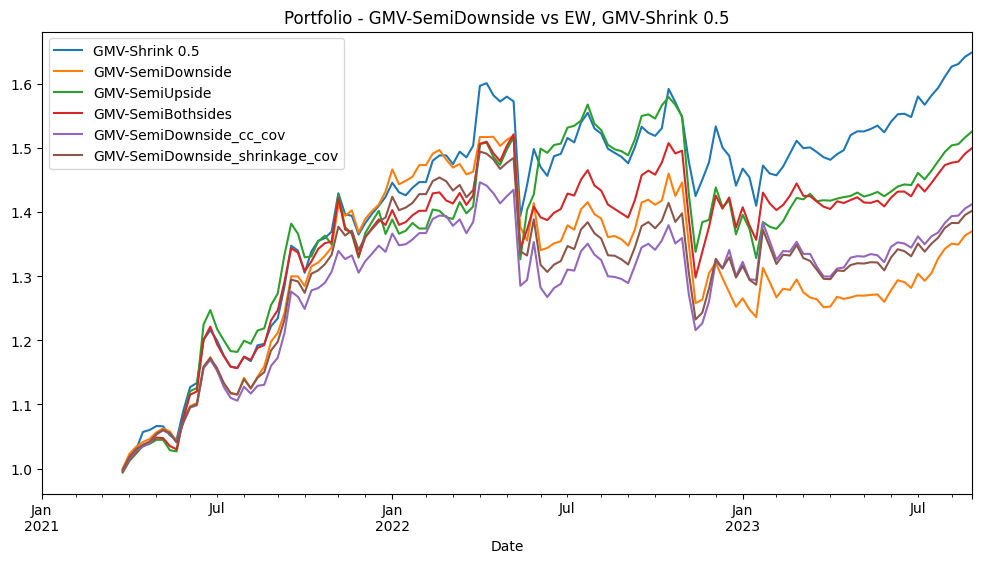

In [ ]:
mv_scc_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_cc_cov)
mv_sshrink_r = backtest_ws(data, estimation_window=12, weighting=weight_gmv, cov_estimator=semidownside_shrinkage_cov)
btr = pd.DataFrame({'GMV-Shrink 0.5': mv_sh_r, 'GMV-SemiDownside': mv_sd_r, 'GMV-SemiUpside': mv_su_r, 'GMV-SemiBothsides': mv_sb_r,
                    'GMV-SemiDownside_cc_cov': mv_scc_r, 'GMV-SemiDownside_shrinkage_cov': mv_sshrink_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio - GMV-SemiDownside vs EW, GMV-Shrink 0.5")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)